## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
from pathlib import Path

if os.name == 'nt':
    PATH = str(Path.home()) + "\\Documents\\GitHub\\planet-amazon-deforestation\\input\\"
else:
    PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

if False:
    os.makedirs('data/planet/models', exist_ok=True)
    os.makedirs('/cache/planet/tmp', exist_ok=True)

    !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
    !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
    !ln -s /cache/planet/tmp {PATH}

In [5]:
ls "{PATH}"

 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 2494-B701

 Verzeichnis von C:\Users\Christian Klukas\Documents\GitHub\planet-amazon-deforestation\input

04.01.2018  22:03    <DIR>          .
04.01.2018  22:03    <DIR>          ..
08.05.2017  20:00    <DIR>          __MACOSX
01.01.2018  10:44           157.221 sample_submission_v2.csv.zip
01.01.2018  10:44           112.887 test_v2_file_mapping.csv.zip
02.01.2018  22:23    <DIR>          test-jpg
19.04.2017  23:10       668.989.440 test-jpg.tar
01.01.2018  09:53       632.362.315 test-jpg.tar.7z
02.01.2018  22:23    <DIR>          test-jpg-additional
06.05.2017  05:33       336.865.280 test-jpg-additional.tar
01.01.2018  10:44       318.407.195 test-jpg-additional.tar.7z
04.01.2018  22:03    <DIR>          test-tif-v2
04.01.2018  19:00    <DIR>          tmp
08.05.2017  19:52         1.432.177 train_v2.csv
01.01.2018  10:44           162.930 train_v2.csv.zip
02.01.2018  22:23    <DIR>          train-jpg
19.04.2017  22

## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path):
    return glob(f'{path}/*.*')[0]

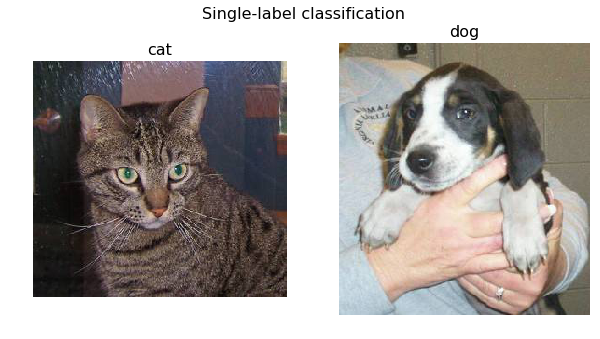

In [8]:
if os.name == 'nt':
    dc_path = str(Path.home()) + "\\Development\\kaggle\\dogscats\\data\\valid\\"
else:
    dc_path = "data/dogscats/valid/"

list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

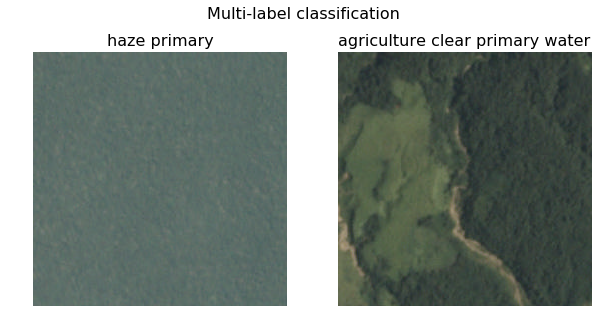

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

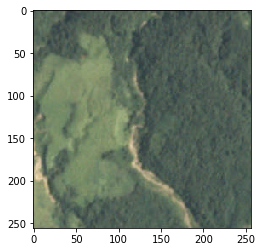

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.21894  0.31245  0.80436]                                                                                  

Wall time: 19.6 s


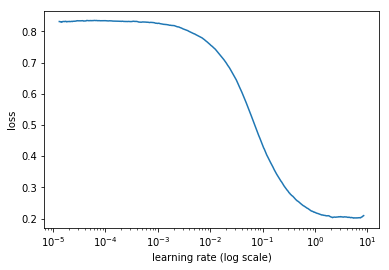

In [22]:
%time lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.2

In [ ]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  2%|█                                                                     | 8/506 [00:00<00:41, 11.91it/s, loss=0.829]

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'lesson2_{sz}')

In [ ]:
learn.load(f'lesson2_{sz}')

In [ ]:
%time log_preds,y = learn.TTA()
f2(log_preds.mean(0), y)

### End